In [0]:
from google.colab import drive
drive.mount('/gdrive')
import shutil, os


print('Continue?(1/0)')
continue_training=bool(int(input()))
if not continue_training:
    try:
        shutil.rmtree("/gdrive/My Drive/GAN/SIGAN/SIGAN_imgs/")
    except: pass
    os.mkdir("/gdrive/My Drive/GAN/SIGAN/SIGAN_imgs")
    try:
        shutil.rmtree("/gdrive/My Drive/GAN/SIGAN/SIGAN_checkpoints/")
    except: pass
    os.mkdir("/gdrive/My Drive/GAN/SIGAN/SIGAN_checkpoints")

In [0]:
print('Continue?(1=YES/0=NO)')
continue_training=bool(int(input()))

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
!pip install -q imageio
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import cv2
import random
import time
import shutil, os
from tensorflow.keras import layers

from IPython import display
from tqdm import tqdm

from google.colab import drive
drive.mount('/gdrive')
path = "/gdrive/My Drive/GAN/"
folder = "SIGAN/VEAGAN"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
size = (64, 64, 3)
imgs = []
files = os.listdir(path+"pokemon/")
random.shuffle(files)
file_range = 10 if len(files)-1 > 4000 else len(files)-1
for i in tqdm(range(0, file_range)):
    img = mpimg.imread(path+"pokemon/"+str(files[i]))
    img = cv2.resize(img, (size[0], size[1]), interpolation = cv2.INTER_AREA)
#     img = img / 255.0
    imgs.append(img)
    

train_images = np.array(imgs).astype('float32')
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

100%|██████████| 868/868 [00:47<00:00, 18.20it/s]


In [0]:
def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(layers.GaussianNoise(1, input_shape=size))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.LeakyReLU())
    
    return model

encoder = make_encoder_model()

encoded = encoder(np.array([train_images[0]]))

print(encoded)    

tf.Tensor(
[[-0.01933502  0.07705119  0.02623885  0.13333708 -0.03421878 -0.02331114
  -0.01167911  0.11750989 -0.0185968  -0.04761984 -0.02691963  0.24474792
  -0.00604792  0.02881204 -0.0185718  -0.01832281  0.15734623  0.02335312
  -0.02355824 -0.04308983  0.06021589  0.12644911  0.11422729 -0.05286391
   0.07134112 -0.00402683  0.20712017 -0.01169051  0.14215536 -0.0116812
  -0.01841103  0.14431882 -0.05338033 -0.02224477 -0.02817365 -0.04494856
  -0.02598218  0.04199674 -0.02288019 -0.04081083 -0.03020927 -0.01800575
   0.14952776  0.09755319  0.0497903  -0.06087922  0.08679792  0.10076728
  -0.01121486  0.17513406  0.21028085 -0.01581195 -0.03937324  0.0649579
  -0.02078052 -0.01192556  0.33849734 -0.00495482  0.09208536 -0.01441449
   0.00549524 -0.01276744 -0.04761648  0.17041975  0.1339687   0.15716057
  -0.04334353  0.19117962 -0.00828367 -0.01507522 -0.02543353 -0.00575356
   0.01307378  0.25350472  0.14639     0.02207076  0.19308095 -0.07956833
  -0.0968646  -0.01212641  0.

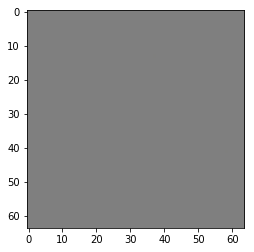

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 64, 64, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

generator = make_generator_model()

# noise = tf.random.normal([1, 100])
generated_image = generator(encoded, training=False)

plt.imshow((generated_image[0, :, :, :].numpy() * 127.5 + 127.5).astype('int32'))

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=size))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))#, activation='softmax'))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[4.0142637e-05]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MSE

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy_logits(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_logits(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output, input_img, generated_img, generated_image_with_gaus):
    gama = 0.1
    gan_loss = cross_entropy_logits(tf.ones_like(fake_output), fake_output)
    encoder_loss = MSE(input_img, generated_img)
    regulerizer = cross_entropy(generated_img, generated_image_with_gaus)
    total_loss = gan_loss + encoder_loss + gama*regulerizer
    return total_loss


encoder_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = path + 'SIGAN/VAEGAN_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(encoder_optimizer=generator_optimizer,
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 encoder=encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 49

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
Gaus_noise = layers.GaussianNoise(1)


@tf.function
def train_step(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        encoded_imgs = encoder(images, training=True)
        
        generated_images = generator(encoded_imgs, training=True)
        generated_images_with_gaus = Gaus_noise(generated_images)

        real_output = discriminator(Gaus_noise(images), training=True)
        fake_output = discriminator(generated_images_with_gaus, training=True)

        gen_loss = generator_loss(fake_output, images, generated_images, generated_images_with_gaus)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables+encoder.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables+encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save the model every 15 epochs
        if (epoch) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(7,7))

    for i in range(predictions.shape[0]):
        plt.subplot(7, 7, i+1)
        plt.imshow((predictions[i, :, :, :].numpy() * 127.5 + 127.5).astype('int32'))
        plt.axis('off')

    plt.savefig(path+'SIGAN/VAEGAN_imgs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
# continue_training = True
# if continue_training:
#     checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

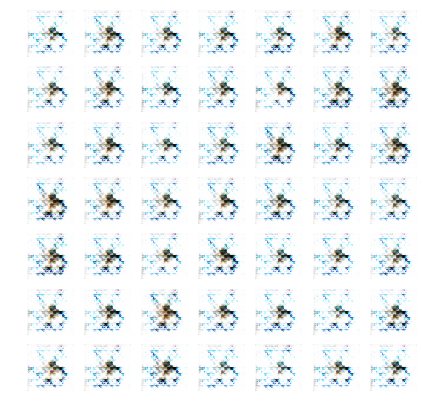

Time for epoch 406 is 8.009762048721313 sec
Time for epoch 407 is 3.4764184951782227 sec
Time for epoch 408 is 3.725294828414917 sec
Time for epoch 409 is 3.739090919494629 sec
Time for epoch 410 is 3.7452590465545654 sec
Time for epoch 411 is 3.7312159538269043 sec
Time for epoch 412 is 3.7693989276885986 sec
Time for epoch 413 is 3.7256577014923096 sec
Time for epoch 414 is 3.7559852600097656 sec
Time for epoch 415 is 2.957395553588867 sec


KeyboardInterrupt: ignored

In [0]:
%%time
train(train_dataset, EPOCHS)

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)